## EDA & 결측치 처리 
- 모델 돌릴때 credit_data / investment_data 결측치 제거 필수 
- final_features 에서 결측치 제거 후 credit_data_model / investment_data_model에 반영 
    - 원본 final_features / credit_data_web / investment_data_web는 바뀌면 X 


### credit_data 결측치 
- ebitda_to_interest_expense 7
- market_capitalization 39

### investment_data 결측치 
- interest_coverage_ratio 7
- earnings_per_share 39
- book_value_per_share 39
- price_earnings_ratio 39
- price_to_book_ratio 39
- price_cash_flow_ratio 39
- enterprise_value_to_ebitda 39
- market_capitalization 39
- accounts_receivable_turnover 12
- inventory_turnover 77
- accounts_payable_turnover 10 




In [1]:
import pymysql
import pandas as pd
import numpy as np
import warnings
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)

username = "multi"
password = "*****!"
hostname = "ec2-15-152-211-160.ap-northeast-3.compute.amazonaws.com"
database_name = "Data_Warehouse"

cnx = pymysql.connect(
    user=username,
    password=password,
    host=hostname,
    database=database_name,
)

query = "SELECT * FROM Data_Warehouse.final_features;"
data = pd.read_sql(query, cnx)
cnx.close()

/var/folders/_r/qrlg6jnd1l5b_xdkq486q0zr0000gn/T/ipykernel_34472/822524164.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, cnx)


In [2]:
data.columns    

Index(['corp', 'stock_code', 'sector', 'year', 'revenue', 'cost_of_sales',
       'gross_profit', 'operating_income', 'net_income', 'ebit', 'ebitda',
       'total_equity', 'total_assets', 'total_liabilities', 'current_assets',
       'current_liabilities', 'non_current_liabilities', 'short_borrowing',
       'long_borrowing', 'cash_and_equivalents', 'retained_earnings',
       'tangible_assets', 'intangible_assets', 'accounts_receivable',
       'inventory', 'accounts_payable', 'outstanding_shares',
       'cash_flow_operating', 'selling_general_administrative_expenses',
       'cash_flow_investing', 'cash_flow_financing', 'long_term_assets',
       'interest', 'tax', 'stock_price', 'market_capitalization', 'borrowings',
       'net_liabilities', 'cash_flow_per_share'],
      dtype='object')

### 원본 credit_data / investment_data 확인 

In [3]:
credit_data = data[["corp", "stock_code", "sector", "year"]].copy()

# Additional columns to data DataFrame
data.loc[:, "net_borrowings"] = data["borrowings"] - data["cash_and_equivalents"]
data.loc[:, "quick_assets"] = data["current_assets"] - data["inventory"]

# Credit Data Calculations
credit_data.loc[:, "ebitda_margin"] = (data["ebitda"] / data["revenue"]) * 100
credit_data.loc[:, "ebitda_to_interest_expense"] = data["ebitda"] / data["interest"] * 100
credit_data.loc[:, "debt_ratio"] = data["total_liabilities"] / data["total_equity"] * 100
credit_data.loc[:, "dependence_on_net_borrowings"] = data["net_borrowings"] / data["total_assets"] * 100
credit_data.loc[:, "net_borrowings_to_ebitda"] = data["net_borrowings"] / data["ebitda"] * 100
credit_data.loc[:, "revenue"] = data["revenue"]
credit_data.loc[:, "cogs"] = data["cost_of_sales"]
credit_data.loc[:, "selling_general_administrative_expenses"] = data["selling_general_administrative_expenses"]
credit_data.loc[:, "ebit"] = data["ebit"]
credit_data.loc[:, "ebit_margin"] = (data["ebit"] / data["revenue"]) * 100
credit_data.loc[:, "ebitda_to_sales_revenue"] = data["ebitda"] / data["revenue"] * 100
credit_data.loc[:, "total_assets"] = data["total_assets"]
credit_data.loc[:, "return_on_assets"] = (data["net_income"] / data["total_assets"]) * 100
credit_data.loc[:, "ebitda"] = data["ebitda"]
credit_data.loc[:, "financial_expenses"] = data["interest"]
credit_data.loc[:, "corporate_tax"] = data["tax"]
credit_data.loc[:, "operating_cash_flow"] = data["cash_flow_operating"]
credit_data.loc[:, "free_cash_flow"] = data["cash_flow_operating"] - data["cash_flow_investing"]
credit_data.loc[:, "total_liabilities"] = data["total_liabilities"]
credit_data.loc[:, "total_equity"] = data["total_equity"]
credit_data.loc[:, "total_borrowings"] = data["borrowings"]
credit_data.loc[:, "net_borrowings"] = data["net_borrowings"]
credit_data.loc[:, "borrowing_dependency"] = data["borrowings"] / data["total_assets"] * 100
credit_data.loc[:, "total_borrowings_to_ebitda"] = data["borrowings"] / data["ebitda"] * 100
credit_data.loc[:, "debt_to_net_income_ratio"] = data["total_liabilities"] / data["net_income"] * 100
credit_data.loc[:, "total_assets_leverage"] = data["total_assets"] / data["total_equity"] * 100
credit_data.loc[:, "current_liabilities"] = data["current_liabilities"]
credit_data.loc[:, "working_capital"] = data["current_assets"] - data["current_liabilities"]
credit_data.loc[:, "current_liabilities_ratio"] = data["current_liabilities"] / data["current_assets"] * 100
credit_data.loc[:, "quick_assets"] = data["quick_assets"]
credit_data.loc[:, "quick_ratio"] = data["quick_assets"] / data["current_liabilities"] * 100
credit_data.loc[:, "cash_and_cash_equivalents"] = data["cash_and_equivalents"]
credit_data.loc[:, "short_term_borrowings"] = data["short_borrowing"]
credit_data.loc[:, "days_sales_outstanding"] = (data["accounts_receivable"] / data["revenue"]) * 365
credit_data.loc[:, "market_capitalization"] = data["market_capitalization"]

# Replace infinity values with NaN
credit_data = credit_data.replace([np.inf, -np.inf], np.nan)

In [4]:
investment_data = data[["corp", "stock_code", "sector", "year"]].copy()

data["earnings_per_share"] = data["net_income"] / data["outstanding_shares"]
data["book_value_per_share"] = data["total_equity"] / data["outstanding_shares"]

# 수익성 (Profitability)
investment_data["gross_profit_margin"] = (data["gross_profit"] / data["revenue"]) * 100
investment_data["operating_profit_margin"] = (data["operating_income"] / data["revenue"]) * 100
investment_data["net_profit_margin"] = (data["net_income"] / data["revenue"]) * 100
investment_data["ebitda_margin"] = (data["ebitda"] / data["revenue"]) * 100
investment_data["return_on_equity"] = (data["net_income"] / data["total_equity"]) * 100
investment_data["return_on_assets"] = (data["net_income"] / data["total_assets"]) * 100
investment_data["return_on_invested_capital"] = (data["ebit"] - data["tax"]) / (data["borrowings"] + data["total_equity"] - data["cash_and_equivalents"]) * 100

# 안정성 (Stability)
investment_data["debt_ratio"] = data["total_liabilities"] / data["total_equity"] * 100
investment_data["current_ratio"] = data["current_assets"] / data["current_liabilities"] * 100
investment_data["quick_ratio"] = (data["current_assets"] - data["inventory"]) / data["current_liabilities"] * 100
investment_data["non_current_debt_ratio"] = data["non_current_liabilities"] / data["total_equity"] * 100
investment_data["equity_ratio"] = data["total_equity"] / data["total_assets"] * 100
investment_data["interest_coverage_ratio"] = data["operating_income"] / data["interest"] * 100
investment_data["debt_to_equity_ratio"] = data["borrowings"] / data["total_equity"] * 100
investment_data["net_debt_ratio"] = (data["total_liabilities"] - data["cash_and_equivalents"]) / data["total_equity"] * 100
investment_data["retention_ratio"] = data["retained_earnings"] / data["net_income"] * 100

# 가치지표 (Valuation Ratios)
investment_data["earnings_per_share"] = data["earnings_per_share"]
investment_data["book_value_per_share"] = data["book_value_per_share"]
investment_data["price_earnings_ratio"] = data["stock_price"] / data["earnings_per_share"]
investment_data["price_to_book_ratio"] = data["stock_price"] / data["book_value_per_share"]
investment_data["price_cash_flow_ratio"] = data["stock_price"] / (data["cash_flow_operating"] / data["outstanding_shares"])
investment_data["enterprise_value_to_ebitda"] = (data["market_capitalization"] + data["borrowings"] - data["cash_and_equivalents"]) / data["ebitda"]

investment_data["market_capitalization"] = data["market_capitalization"]

# 성장성 (Growth): 성장성 대신 성장성에 해당하는 계정 넣어도 성장성이 반영 됨 
investment_data['revenue'] = data['revenue']
investment_data['operating_income'] = data['operating_income']
investment_data['net_income'] = data['net_income']
investment_data['total_assets'] = data['total_assets']
investment_data['tangible_assets'] = data['tangible_assets']
investment_data['total_liabilities'] = data['total_liabilities']
investment_data['total_equity'] = data['total_equity']

# 활동성 (Efficiency)
investment_data["total_asset_turnover"] = data["revenue"] / data["total_assets"] * 100
investment_data["return_on_equity"] = (data["net_income"] / data["total_equity"]) * 100
investment_data["net_working_capital_turnover"] = (data["revenue"] / (data["current_assets"] - data["current_liabilities"])) * 100
investment_data["tangible_asset_turnover"] = (data["revenue"] / data["tangible_assets"]) * 100
investment_data["accounts_receivable_turnover"] = (data["revenue"] / data["accounts_receivable"]) * 100
investment_data["inventory_turnover"] = (data["cost_of_sales"] / data["inventory"]) * 100
investment_data["accounts_payable_turnover"] = (data["cost_of_sales"] / data["accounts_payable"]) * 100

investment_data = investment_data.replace([np.inf, -np.inf], np.nan)


In [5]:
print(credit_data.isna().sum())
print(investment_data.isna().sum()) 

corp                                        0
stock_code                                  0
sector                                      0
year                                        0
ebitda_margin                               0
ebitda_to_interest_expense                  7
debt_ratio                                  0
dependence_on_net_borrowings                0
net_borrowings_to_ebitda                    0
revenue                                     0
cogs                                        0
selling_general_administrative_expenses     0
ebit                                        0
ebit_margin                                 0
ebitda_to_sales_revenue                     0
total_assets                                0
return_on_assets                            0
ebitda                                      0
financial_expenses                          0
corporate_tax                               0
operating_cash_flow                         0
free_cash_flow                    

NULL DATA FOR CREDIT_DATA


ebitda_to_interest_expense

count    3.097000e+03
mean     4.365397e+03
std      7.610023e+04
min     -1.312671e+05
25%      1.251724e+01
50%      2.783991e+02
75%      9.202511e+02
max      3.702125e+06
Name: ebitda_to_interest_expense, dtype: float64


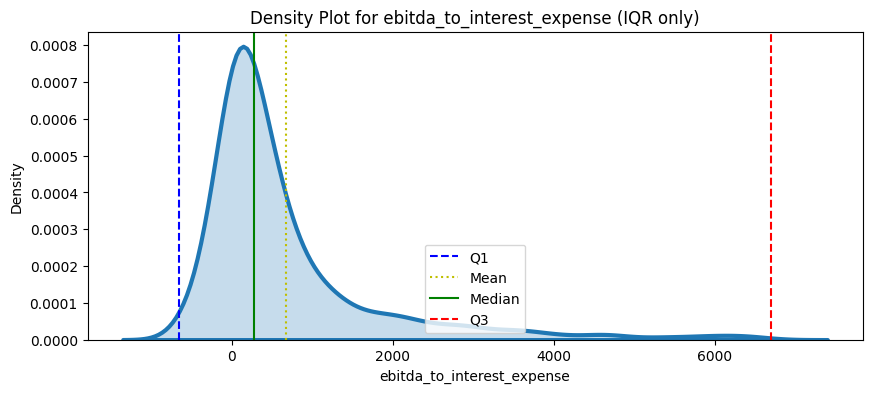

market_capitalization

count    3.065000e+03
mean     2.760645e+12
std      2.308866e+13
min      0.000000e+00
25%      1.142460e+11
50%      2.751000e+11
75%      9.604862e+11
max      8.918334e+14
Name: market_capitalization, dtype: float64


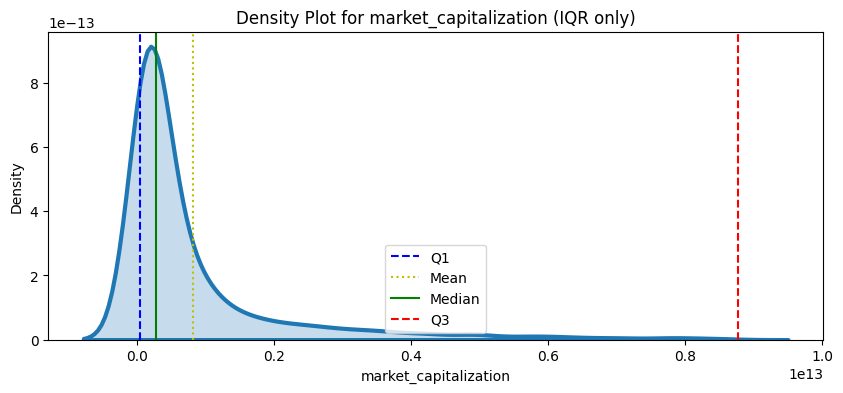

NULL DATA FOR INVESTMENT_DATA


interest_coverage_ratio

count    3.097000e+03
mean     1.068656e+04
std      3.206836e+05
min     -4.061502e+05
25%      4.849593e+01
50%      2.692715e+02
75%      8.595272e+02
max      1.693218e+07
Name: interest_coverage_ratio, dtype: float64


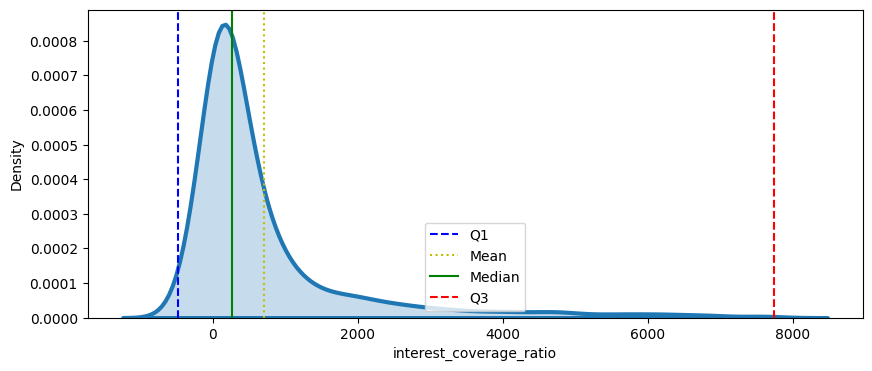

earnings_per_share

count      3065.000000
mean       3786.537393
std       15621.542754
min     -128166.342192
25%         -12.548881
50%         619.981856
75%        3388.195017
max      307373.863237
Name: earnings_per_share, dtype: float64


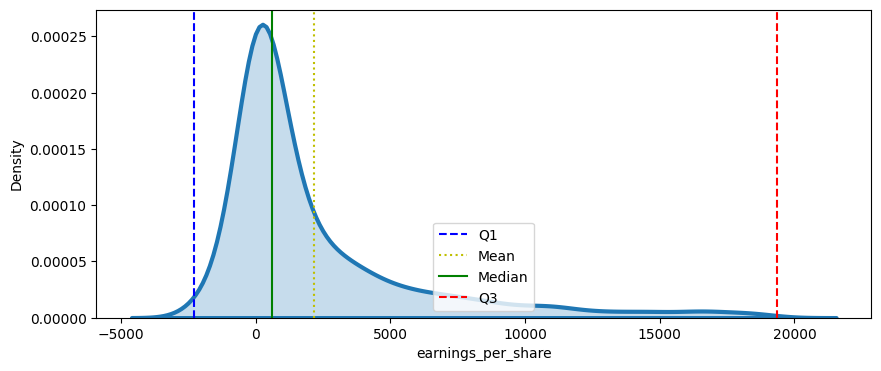

book_value_per_share

count    3.065000e+03
mean     6.578448e+04
std      1.901882e+05
min     -6.677692e+03
25%      5.263218e+03
50%      1.513890e+04
75%      5.636778e+04
max      3.779253e+06
Name: book_value_per_share, dtype: float64


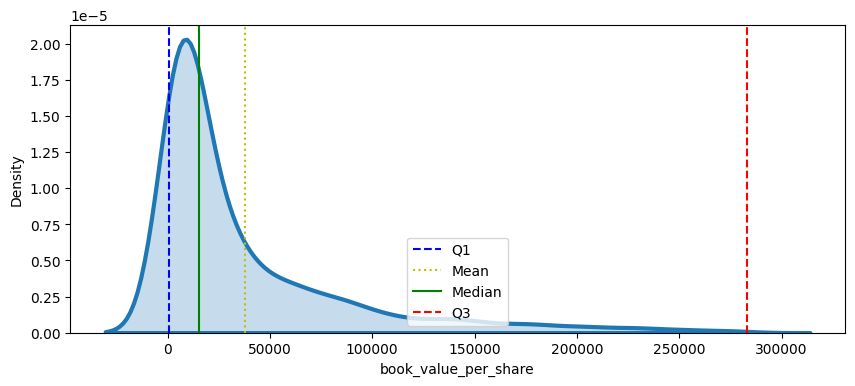

price_earnings_ratio

count      3065.000000
mean        172.164342
std        7688.253676
min      -15762.066526
25%          -1.122671
50%           7.577958
75%          17.515441
max      419797.678852
Name: price_earnings_ratio, dtype: float64


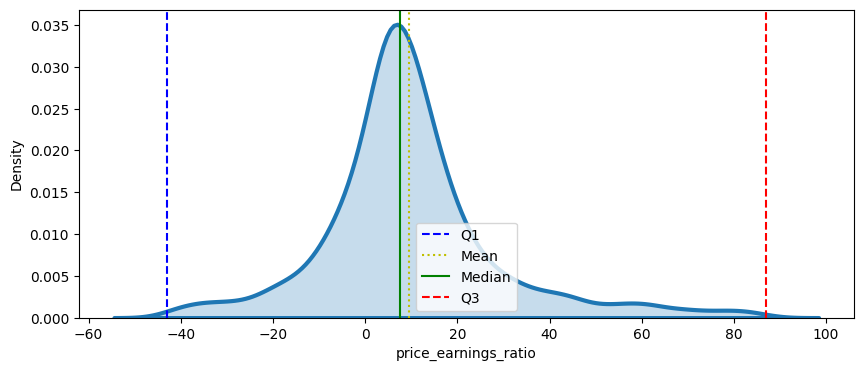

price_to_book_ratio

count    3065.000000
mean        8.695436
std       146.597401
min     -1251.321964
25%         0.437329
50%         0.748253
75%         1.486892
max      4834.020619
Name: price_to_book_ratio, dtype: float64


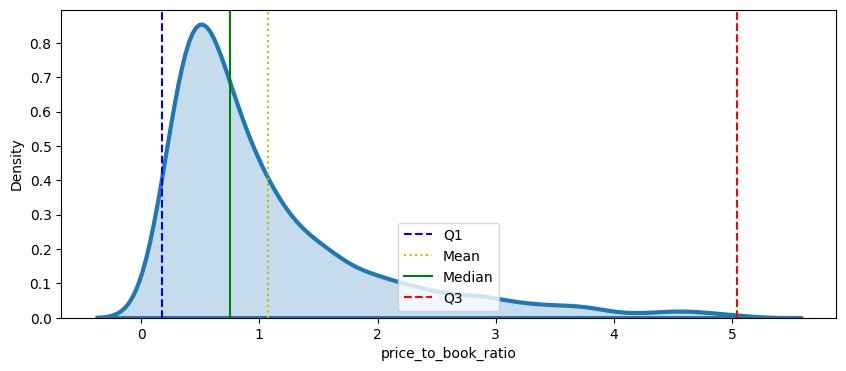

price_cash_flow_ratio

count      3065.000000
mean         54.754673
std        2492.905396
min      -51315.026128
25%           1.034362
50%           4.811056
75%          11.842602
max      102046.568082
Name: price_cash_flow_ratio, dtype: float64


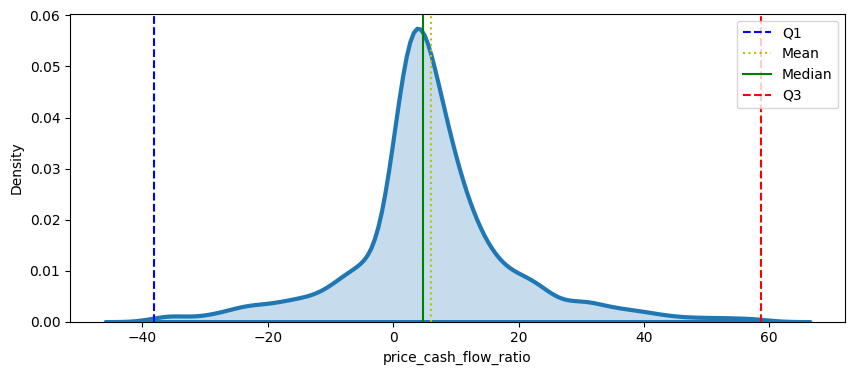

enterprise_value_to_ebitda

count      3065.000000
mean        -41.822802
std        3095.934659
min     -154916.970999
25%           1.012109
50%           6.832327
75%          15.164533
max       33428.436857
Name: enterprise_value_to_ebitda, dtype: float64


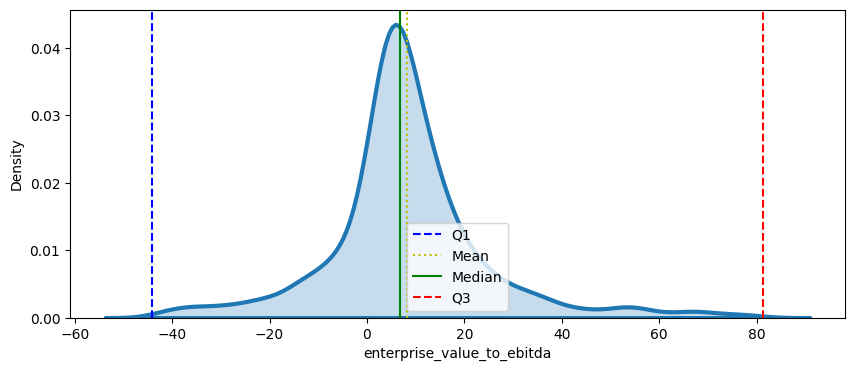

accounts_receivable_turnover

count    3.092000e+03
mean     2.234440e+03
std      3.802427e+04
min      1.684143e+01
25%      4.849910e+02
50%      6.547619e+02
75%      9.107191e+02
max      1.813546e+06
Name: accounts_receivable_turnover, dtype: float64


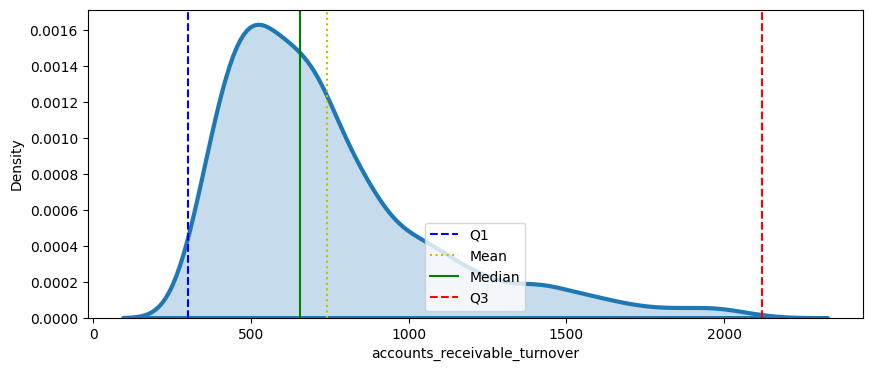

inventory_turnover

count    3.027000e+03
mean     1.763287e+04
std      2.925942e+05
min      0.000000e+00
25%      3.417271e+02
50%      5.828694e+02
75%      1.043814e+03
max      8.433314e+06
Name: inventory_turnover, dtype: float64


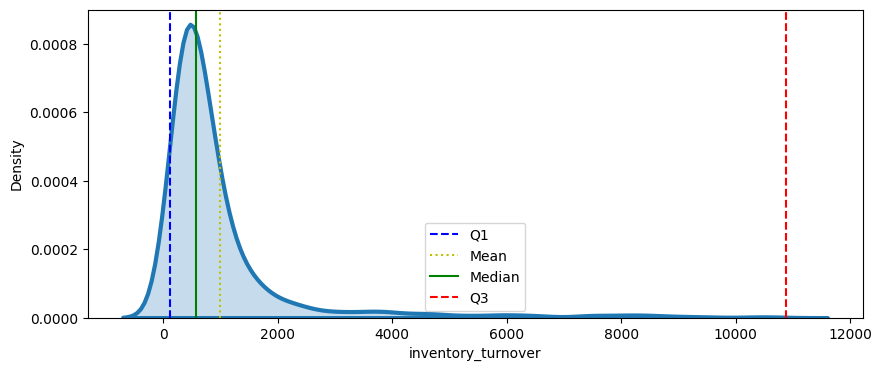

accounts_payable_turnover

count    3.094000e+03
mean     9.565649e+03
std      2.267296e+05
min      0.000000e+00
25%      4.991792e+02
50%      7.366614e+02
75%      1.088366e+03
max      8.261546e+06
Name: accounts_payable_turnover, dtype: float64


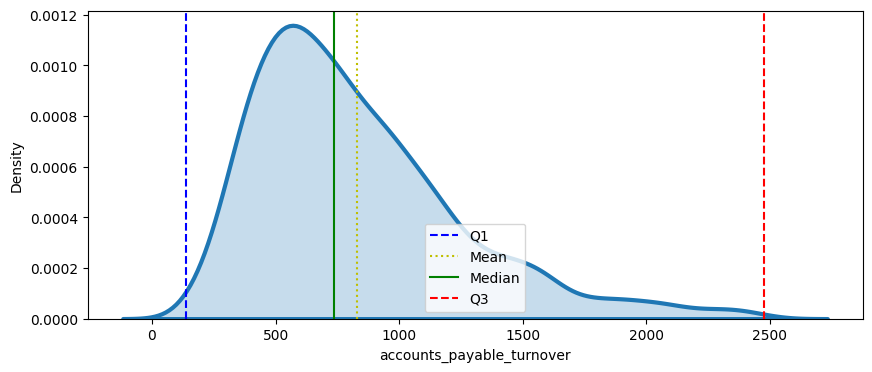

In [6]:
credit_data_null = ['ebitda_to_interest_expense', 'market_capitalization']

investment_data_null = ['interest_coverage_ratio', 'earnings_per_share', 'book_value_per_share', 'price_earnings_ratio',
             'price_to_book_ratio', 'price_cash_flow_ratio', 'enterprise_value_to_ebitda',
             'accounts_receivable_turnover', 'inventory_turnover', 'accounts_payable_turnover']

print("NULL DATA FOR CREDIT_DATA", end="\n\n\n")

for account in credit_data_null: 
    print(account, end="\n\n") 

    plt.figure(figsize=(10, 4))
    account_data = credit_data[account].dropna() 
    Q1 = account_data.quantile(0.05)
    Q3 = account_data.quantile(0.95)
    IQR = account_data[(account_data >= Q1) & (account_data <= Q3)]
    
    print(account_data.describe())

    sns.kdeplot(IQR, fill=True, linewidth=3)

    plt.axvline(Q1, color='b', linestyle='--', label='Q1')
    plt.axvline(np.mean(IQR), color='y', linestyle=':', label='Mean')
    plt.axvline(np.median(IQR), color='g', linestyle='-', label='Median')
    plt.axvline(Q3, color='r', linestyle='--', label='Q3')

    plt.title('Density Plot for '+account + ' (IQR only)')
    plt.xlabel(account)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

print("NULL DATA FOR INVESTMENT_DATA", end="\n\n\n")

for account in investment_data_null: 
    print(account, end="\n\n") 

    plt.figure(figsize=(10, 4))
    account_data = investment_data[account].dropna() 
    Q1 = account_data.quantile(0.05)
    Q3 = account_data.quantile(0.95)
    IQR = account_data[(account_data >= Q1) & (account_data <= Q3)]
    
    print(account_data.describe())

    sns.kdeplot(IQR, fill=True, linewidth=3)
    
    plt.axvline(Q1, color='b', linestyle='--', label='Q1')
    plt.axvline(np.mean(IQR), color='y', linestyle=':', label='Mean')
    plt.axvline(np.median(IQR), color='g', linestyle='-', label='Median')
    plt.axvline(Q3, color='r', linestyle='--', label='Q3')

    plt.xlabel(account)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

### final_features 결측치 제거 

#### outstanding_shares
- 발행주식수 결측치가 있는 기업 직접 찾아서 상장 공모주식수 개수로 채우기
- 예: HD현대중공업 2019년도, SK아이테크놀로지 2019, ... 

In [11]:
null_outstanding_shares = data[data['outstanding_shares']==0][['corp', 'year']]

for idx, (corp, year) in null_outstanding_shares.iterrows():
    print(corp, year, end=', ')

HD현대중공업 2019, SK아이이테크놀로지 2019, SK아이이테크놀로지 2020, 교촌에프앤비 2018, 교촌에프앤비 2019, 농심 2018, 농심 2019, 농심 2020, 농심 2021, 농심 2022, 명신산업 2018, 명신산업 2019, 솔루엠 2018, 수산인더스트리 2020, 수산인더스트리 2021, 쏘카 2020, 쏘카 2021, 씨티알모빌리티 2018, 아주스틸 2019, 아주스틸 2020, 에스케이바이오팜 2018, 에스케이바이오팜 2019, 조선내화 2018, 조선내화 2019, 조선내화 2020, 조선내화 2021, 조선내화 2022, 카카오페이 2019, 카카오페이 2020, 하이브 2018, 하이브 2019, 한컴라이프케어 2019, 한컴라이프케어 2020, 한화시스템 2018, 현대백화점 2018, 현대백화점 2019, 현대백화점 2020, 현대백화점 2021, 현대백화점 2022, 

In [128]:
fill_outstanding_shares = [18000000, 21390000, 21390000, 5800000, 5800000, 6082642,
                           6082642, 6082642, 6082642, 6082642, 6500, 6500, 17000,
                           35000, 35000, 28000, 28000, 6000, 15100, 15100, 49000,
                           49000, 28144832, 28144832, 28144832, 28144832, 28144832,
                           90000, 90000, 135000, 135000, 13700, 13700, 12250,
                           23402441, 23402441, 23402441, 23402441, 23402441]

for (index, row), fill_value in zip(null_outstanding_shares.iterrows(), fill_outstanding_shares):
    corp, year = row['corp'], row['year']
    data.loc[(data['corp'] == corp) & (data['year'] == year), 'outstanding_shares'] = fill_value

#### stock_price
1. 최근 결측치 공모가로 데이터 채워넣기 
2. 결측치가 더 많으면 계산: <b>해당년도 주가 = (해당년도 매출액 / (해당년도+1) 매출액) * (해당년도+1) 주가</b>

In [129]:
null_stock_price_corp = data[data['stock_price'].isna()]['corp'].unique().tolist()
null_stock_price_corp.append('지누스')

stock_price_fill_years = ['2020', '2021', '2020', '2020', '2019', '2018', '2020', '2019', '2020', '2021', '2021', '2018', '2020', '2019', '2019', '2020', '2020', '2019', '2020', '2018', '2018', '2018']

fill_stock_price = [
    60000, 300000, 65000, 105000, 12300, 13000, 59000, 6500, 17000, 35000, 28000, 6000, 15100, 49000, 7500, 90000, 498000, 135000, 13700, 12250, 48000, 70000
]

for corp, year, price in zip(null_stock_price_corp, stock_price_fill_years, fill_stock_price):
    data.loc[(data['corp'] == corp) & (data['year'] == year), 'stock_price'] = price

In [130]:
data = data.sort_values(by='year', ascending=False)

for index, row in data.iterrows():
    if pd.isna(row['stock_price']):
        corp = row['corp']
        year = int(row['year'])

        if ((data['corp'] == corp) & (data['year'] == str(year+1))).any():
            next_year_row = data[(data['corp'] == corp) & (data['year'] == str(year+1))].iloc[0]

            new_price = (row['revenue'] / next_year_row['revenue']) * next_year_row['stock_price']
            
            data.at[index, 'stock_price'] = new_price
    
data = data.sort_values(['corp', 'year'])

### market_capitalization

In [131]:
if data['market_capitalization'].isna().any(): 
    data['market_capitalization'] = data['market_capitalization'].fillna(data['stock_price'] * data['outstanding_shares'])

### interest

In [132]:
data = data[data['interest'] != 0]

### Credit Data

In [133]:
credit_data = data[["corp", "stock_code", "sector", "year"]].copy()

data.loc[:, "net_borrowings"] = data["borrowings"] - data["cash_and_equivalents"]
data.loc[:, "quick_assets"] = data["current_assets"] - data["inventory"]

credit_data.loc[:, "ebitda_margin"] = (data["ebitda"] / data["revenue"]) * 100
credit_data.loc[:, "ebitda_to_interest_expense"] = data["ebitda"] / data["interest"] * 100
credit_data.loc[:, "debt_ratio"] = data["total_liabilities"] / data["total_equity"] * 100
credit_data.loc[:, "dependence_on_net_borrowings"] = data["net_borrowings"] / data["total_assets"] * 100
credit_data.loc[:, "net_borrowings_to_ebitda"] = data["net_borrowings"] / data["ebitda"] * 100
credit_data.loc[:, "revenue"] = data["revenue"]
credit_data.loc[:, "cogs"] = data["cost_of_sales"]
credit_data.loc[:, "selling_general_administrative_expenses"] = data["selling_general_administrative_expenses"]
credit_data.loc[:, "ebit"] = data["ebit"]
credit_data.loc[:, "ebit_margin"] = (data["ebit"] / data["revenue"]) * 100
credit_data.loc[:, "ebitda_to_sales_revenue"] = data["ebitda"] / data["revenue"] * 100
credit_data.loc[:, "total_assets"] = data["total_assets"]
credit_data.loc[:, "return_on_assets"] = (data["net_income"] / data["total_assets"]) * 100
credit_data.loc[:, "ebitda"] = data["ebitda"]
credit_data.loc[:, "financial_expenses"] = data["interest"]
credit_data.loc[:, "corporate_tax"] = data["tax"]
credit_data.loc[:, "operating_cash_flow"] = data["cash_flow_operating"]
credit_data.loc[:, "free_cash_flow"] = data["cash_flow_operating"] - data["cash_flow_investing"]
credit_data.loc[:, "total_liabilities"] = data["total_liabilities"]
credit_data.loc[:, "total_equity"] = data["total_equity"]
credit_data.loc[:, "total_borrowings"] = data["borrowings"]
credit_data.loc[:, "net_borrowings"] = data["net_borrowings"]
credit_data.loc[:, "borrowing_dependency"] = data["borrowings"] / data["total_assets"] * 100
credit_data.loc[:, "total_borrowings_to_ebitda"] = data["borrowings"] / data["ebitda"] * 100
credit_data.loc[:, "debt_to_net_income_ratio"] = data["total_liabilities"] / data["net_income"] * 100
credit_data.loc[:, "total_assets_leverage"] = data["total_assets"] / data["total_equity"] * 100
credit_data.loc[:, "current_liabilities"] = data["current_liabilities"]
credit_data.loc[:, "working_capital"] = data["current_assets"] - data["current_liabilities"]
credit_data.loc[:, "current_liabilities_ratio"] = data["current_liabilities"] / data["current_assets"] * 100
credit_data.loc[:, "quick_assets"] = data["quick_assets"]
credit_data.loc[:, "quick_ratio"] = data["quick_assets"] / data["current_liabilities"] * 100
credit_data.loc[:, "cash_and_cash_equivalents"] = data["cash_and_equivalents"]
credit_data.loc[:, "short_term_borrowings"] = data["short_borrowing"]
credit_data.loc[:, "days_sales_outstanding"] = (data["accounts_receivable"] / data["revenue"]) * 365
credit_data.loc[:, "market_capitalization"] = data["market_capitalization"]

credit_data = credit_data.replace([np.inf, -np.inf], np.nan)

### Investment Data

In [134]:
investment_data = data[["corp", "stock_code", "sector", "year"]].copy()

data["earnings_per_share"] = data["net_income"] / data["outstanding_shares"]
data["book_value_per_share"] = data["total_equity"] / data["outstanding_shares"]

# 수익성 (Profitability)
investment_data["gross_profit_margin"] = (data["gross_profit"] / data["revenue"]) * 100
investment_data["operating_profit_margin"] = (data["operating_income"] / data["revenue"]) * 100
investment_data["net_profit_margin"] = (data["net_income"] / data["revenue"]) * 100
investment_data["ebitda_margin"] = (data["ebitda"] / data["revenue"]) * 100
investment_data["return_on_equity"] = (data["net_income"] / data["total_equity"]) * 100
investment_data["return_on_assets"] = (data["net_income"] / data["total_assets"]) * 100
investment_data["return_on_invested_capital"] = (data["ebit"] - data["tax"]) / (data["borrowings"] + data["total_equity"] - data["cash_and_equivalents"]) * 100

# 안정성 (Stability)
investment_data["debt_ratio"] = data["total_liabilities"] / data["total_equity"] * 100
investment_data["current_ratio"] = data["current_assets"] / data["current_liabilities"] * 100
investment_data["quick_ratio"] = (data["current_assets"] - data["inventory"]) / data["current_liabilities"] * 100
investment_data["non_current_debt_ratio"] = data["non_current_liabilities"] / data["total_equity"] * 100
investment_data["equity_ratio"] = data["total_equity"] / data["total_assets"] * 100
investment_data["interest_coverage_ratio"] = data["operating_income"] / data["interest"] * 100
investment_data["debt_to_equity_ratio"] = data["borrowings"] / data["total_equity"] * 100
investment_data["net_debt_ratio"] = (data["total_liabilities"] - data["cash_and_equivalents"]) / data["total_equity"] * 100
investment_data["retention_ratio"] = data["retained_earnings"] / data["net_income"] * 100

# 가치지표 (Valuation Ratios)
investment_data["earnings_per_share"] = data["earnings_per_share"]
investment_data["book_value_per_share"] = data["book_value_per_share"]
investment_data["price_earnings_ratio"] = data["stock_price"] / data["earnings_per_share"]
investment_data["price_to_book_ratio"] = data["stock_price"] / data["book_value_per_share"]
investment_data["price_cash_flow_ratio"] = data["stock_price"] / (data["cash_flow_operating"] / data["outstanding_shares"])
investment_data["enterprise_value_to_ebitda"] = (data["market_capitalization"] + data["borrowings"] - data["cash_and_equivalents"]) / data["ebitda"]

investment_data["market_capitalization"] = data["market_capitalization"]

# 성장성 (Growth): 성장성 대신 성장성에 해당하는 계정 넣어도 성장성이 반영 됨 
investment_data['revenue'] = data['revenue']
investment_data['operating_income'] = data['operating_income']
investment_data['net_income'] = data['net_income']
investment_data['total_assets'] = data['total_assets']
investment_data['tangible_assets'] = data['tangible_assets']
investment_data['total_liabilities'] = data['total_liabilities']
investment_data['total_equity'] = data['total_equity']

# 활동성 (Efficiency)
investment_data["total_asset_turnover"] = data["revenue"] / data["total_assets"] * 100
investment_data["return_on_equity"] = (data["net_income"] / data["total_equity"]) * 100
investment_data["net_working_capital_turnover"] = (data["revenue"] / (data["current_assets"] - data["current_liabilities"])) * 100
investment_data["tangible_asset_turnover"] = (data["revenue"] / data["tangible_assets"]) * 100
investment_data["accounts_receivable_turnover"] = (data["revenue"] / data["accounts_receivable"]) * 100
investment_data["inventory_turnover"] = (data["cost_of_sales"] / data["inventory"]) * 100
investment_data["accounts_payable_turnover"] = (data["cost_of_sales"] / data["accounts_payable"]) * 100

investment_data = investment_data.replace([np.inf, -np.inf], np.nan)


### 'accounts_receivable_turnover', 'inventory_turnover', 'accounts_payable_turnover' NULL값 0으로 대체
- 중앙값이 비교적으로 낮아서 (6, 5, 7) 0값 으로 대체


In [135]:
investment_data['accounts_receivable_turnover'] = investment_data['accounts_receivable_turnover'].fillna(0)
investment_data['inventory_turnover'] = investment_data['inventory_turnover'].fillna(0)
investment_data['accounts_payable_turnover'] = investment_data['accounts_payable_turnover'].fillna(0)

### 결측치 처리 확인!

In [136]:
print(credit_data.isna().sum().sum())
print(investment_data.isna().sum().sum())

0
0


### CSV 저장 / MySQL 적제 

In [137]:
credit_data.to_csv('credit_data_model.csv', encoding='utf-8-sig', index=False)
investment_data.to_csv('investment_data_model.csv', encoding='utf-8-sig', index=False)

In [138]:
data_tables = {
    "credit_data_model": credit_data,
    "investment_data_model": investment_data
}

engine = create_engine(
    f"mysql+pymysql://{username}:{password}@{hostname}/{database_name}"
)
Session = sessionmaker(bind=engine)

for table_name, df in data_tables.items():
    try:
        with engine.begin() as connection, Session() as session:
            df.to_sql(
                table_name,
                con=connection,
                if_exists="replace",
                index=False,
                chunksize=1000,
            )
            session.commit()
    except Exception as e:
        print(f"An error occurred while processing {table_name}: {str(e)}")
        session.rollback()